# EXPLORE BIOMODELS

In [1]:
import pySubnetSB.constants as cnn
from pySubnetSB.model_serializer import ModelSerializer
from pySubnetSB.network import Network
import pySubnetSB.constants as cn
from pySubnetSB.subnet_finder import SubnetFinder

import os 

import copy
import numpy as np
import pandas as pd
from sbmlnetwork import SBMLNetwork
import tellurium as te
from typing import List, Tuple
import matplotlib.pyplot as plt
import tellurium as te

# Helpers

In [2]:
BIOMODEL_DIR = "/Users/jlheller/home/Technical/repos/SBMLModel/data"
BIOMODEL_FIILES = [f for f in os.listdir(BIOMODEL_DIR) if f.endswith(".xml")]
MODEL_DIR = "/Users/jlheller/home/Technical/repos/pySubnetSB/data"
SERIALIZATION_FILE = os.path.join(MODEL_DIR, "biomodels_serialized.txt")

In [3]:
REFERENCE_TEST_MODEL = """
A -> B; 1
B -> C; 1
A = 0
B = 0
"""

In [4]:

TARGET_TEST_MODEL = """
S1 -> S2; 2
S2 -> S3; 2
S3 -> S4; 2
A = 0
B = 0
C = 0
"""

In [5]:
def getBiomodel(biomodel_num:int)->Tuple[str, str]:
    """
    Obtains the BioModels file in roadrunner readable (first return value) and printable (second)
    """
    model_str = "BIOMD000000" + str(biomodel_num).zfill(4) + ".xml"
    ffiles = [f for f in BIOMODEL_FIILES if f == model_str]
    if len(ffiles) != 1:
        raise ValueError(f"Invalid biomodels number: {biomodel_num}")
    path = os.path.join(BIOMODEL_DIR, ffiles[0])
    if not os.path.isfile(path):
        raise ValueError(f"Cannot find file {path}.")
    rr = te.loadSBMLModel(path)
    antimony_printable_str = rr.getAntimony()
    antimony_roadrunner_str = antimony_printable_str.replace("\n", ";")
    return antimony_roadrunner_str, antimony_printable_str

# Tests
antimony_rr_str, antimony_prt_str = getBiomodel(608)
assert(isinstance(antimony_rr_str, str))
assert(isinstance(antimony_prt_str, str))
print("OK!")

OK!


In [6]:
def drawModel(model, is_plot=True):
    if "http" in model:
        rr = te.loadSBMLModel(model)
    else:
        rr = te.loada(model) 
    diagram = SBMLNetwork(rr.getSBML())
    diagram.autolayout()
    if is_plot:
        diagram.draw()

# Tests
drawModel(TARGET_TEST_MODEL, is_plot=False)
#drawModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1603310000/4/BIOMD0000000608_url.xml")
print("OK!")

OK!


In [7]:
def findAntimonySubnet(reference_model:str, target_model:str, is_report:bool=True)->pd.DataFrame:
    """
    Finds a subnet of model2 that is model1.
    """
    reference_network = Network.makeFromAntimonyStr(reference_model)
    target_network = Network.makeFromAntimonyStr(target_model)
    finder = SubnetFinder.makeFromCombinations( [reference_network], [target_network],
                 identity=cn.ID_WEAK)
    df = finder.find(is_report=is_report)
    return df

# Test
df = findAntimonySubnet(REFERENCE_TEST_MODEL, TARGET_TEST_MODEL, is_report=False)
assert(len(df.loc[0, 'reference_network']) > 0)
print("OK!")

OK!


In [8]:
#print(df.loc[0, 'reference_network'])

In [9]:
#print(df.loc[0, 'induced_network'])

# Initial Analysis

In [10]:
serializer = ModelSerializer(MODEL_DIR, serialization_file=SERIALIZATION_FILE)
network_collection = serializer.deserialize()
BIOMODEL_NETWORKS = network_collection.networks

In [11]:
num_reactions = [n.num_reaction for n in network_collection.networks]
num_species = [n.num_species for n in network_collection.networks]

/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_89530/1375890876.py:1: RuntimeWarning:

divide by zero encountered in log10



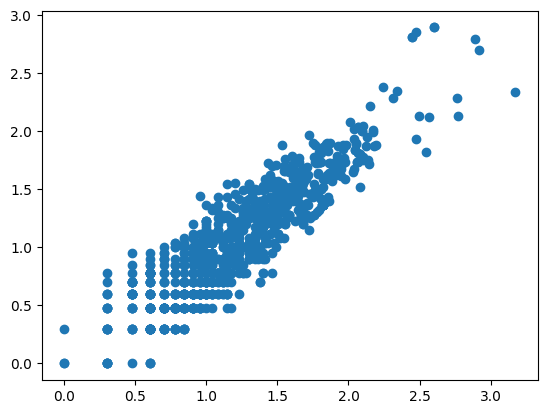

In [12]:
plt.scatter(np.log10(num_reactions), np.log10(num_species))

# Oscillator

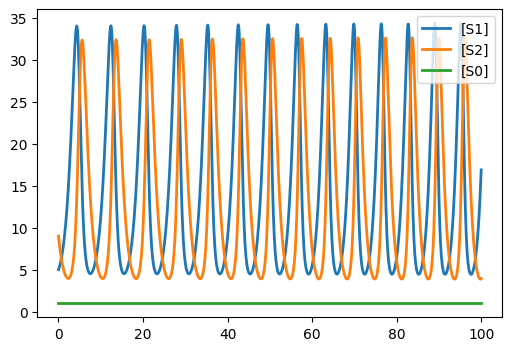

In [13]:
oscillator_model = """
S1 + S2 -> S1 + S1; k1*S1*S2
S2 -> S2 + S2; k2*S2
S0 + S1 -> S0; k3*S0*S1
k1 = 9.63869
k2 = 140.9346
k3 = 130.1286
S0 = 1.0
S1 = 5.0
S2 = 9.0
"""
rr = te.loada(oscillator_model)
rr.simulate(0, 100, 1000)
rr.plot()

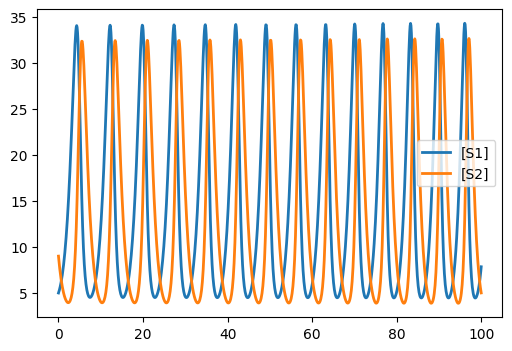

In [14]:
oscillator_model = """
J1: S1 + S2 -> S1 + S1; k1*S1*S2
J2: S2 -> S2 + S2; k2*S2
J3: S1 -> ; k3*S1
k1 = 9.63869
k2 = 140.9346
k3 = 130.1286
S0 = 1.0
S1 = 5.0
S2 = 9.0
"""
rr = te.loada(oscillator_model)
rr.simulate(0, 100, 1000)
rr.plot()

In [15]:
oscillator_network = Network.makeFromAntimonyStr(oscillator_model)
print(oscillator_network)

8334277: 2 species, 3 reactions
  J1: S1 + S2 -> 2.0 S1
  J2: S2 -> 2.0 S2
  J3: S1 -> 


In [16]:
oscillator_network.isStructurallyIdentical(BIOMODEL_NETWORKS[0])

StructurallyIdenticalResult(assignment_pairs=[]; is_truncated=False;

In [17]:
%%time
if False:
    for network in BIOMODEL_NETWORKS:
        if network:
            result = oscillator_network.isStructurallyIdentical(network)
            if result:
                print("Found a match")
                break
        

CPU times: user 10 µs, sys: 47 µs, total: 57 µs
Wall time: 11 µs


# Creating networks of oscillators

In [18]:
!pwd

/Users/jlheller/home/Technical/repos/pySubnetSB/notebooks


In [19]:
OSCILLATOR_SERIAIZED_FILE = "/Users/jlheller/home/Technical/repos/pySubnetSB/data/Oscillators_June_11_A_2024_6877_serializers.txt"

In [20]:
serializer = ModelSerializer(MODEL_DIR, serialization_file=OSCILLATOR_SERIAIZED_FILE)
oscillator_collection = serializer.deserialize()

In [21]:
len(oscillator_collection)

6877

In [22]:
def searchBiomodels(oscillator_networks):
    matched_result = []
    ignore_count = 165
    for idx, o_network in enumerate(oscillator_networks):
        if idx < ignore_count:
            continue
        print(f"Processing oscillator network {o_network.network_name}")
        for b_idx, b_network in enumerate(BIOMODEL_NETWORKS):
            if b_network:
                print(b_network.network_name, o_network.network_name)
                result = o_network.isStructurallyIdentical(b_network, is_subset=True, identity=cn.ID_WEAK)
                if result:
                    matched_result.append((o_network, b_network, result))
                    print(f"Found match for {idx} {o_network.network_name}, {b_network.network_name}")
                    return result

In [23]:
#result = searchBiomodels(oscillator_collection.networks)

In [24]:
#result.assignment_pairs


In [25]:
[(i, n.network_name) for i, n in enumerate(oscillator_collection.networks) if n.network_name == "MrVijviZ_8flbegF_2622_25"]

[(49, 'MrVijviZ_8flbegF_2622_25')]

In [26]:
#[(i, n.num_species, n.num_reaction) for i, n in enumerate(BIOMODEL_NETWORKS[:20])]

# A matched oscillator network

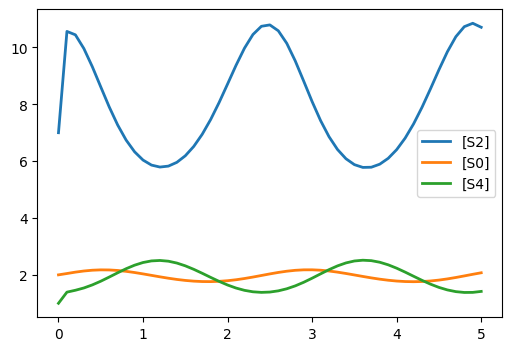

In [27]:
matched_model = """
// M9ODQLMW_XrH3X2B_4148_25
// M9ODQLMW_XrH3X2B_4148_25
// M9ODQLMW_XrH3X2B_4148_25
$S3 -> S2;  S3*19.3591127845924;
S0 -> S4 + S0;  S0*10.3068257839885;
S4 + S2 -> S4;  S4*S2*13.8915863630362;
S2 -> S0 + S2;  S2*0.113616698747501;
S4 + S0 -> S4;  S4*S0*0.240788980014622;
S2 -> S2 + S2;  S2*1.36258363821544;
S2 + S4 -> S2;  S2*S4*1.37438814584166;

S0 = 2; S1 = 5; S2 = 7; S3 = 10; S4 = 1;
"""
rr = te.loada(matched_model)
rr.simulate()
rr.plot()


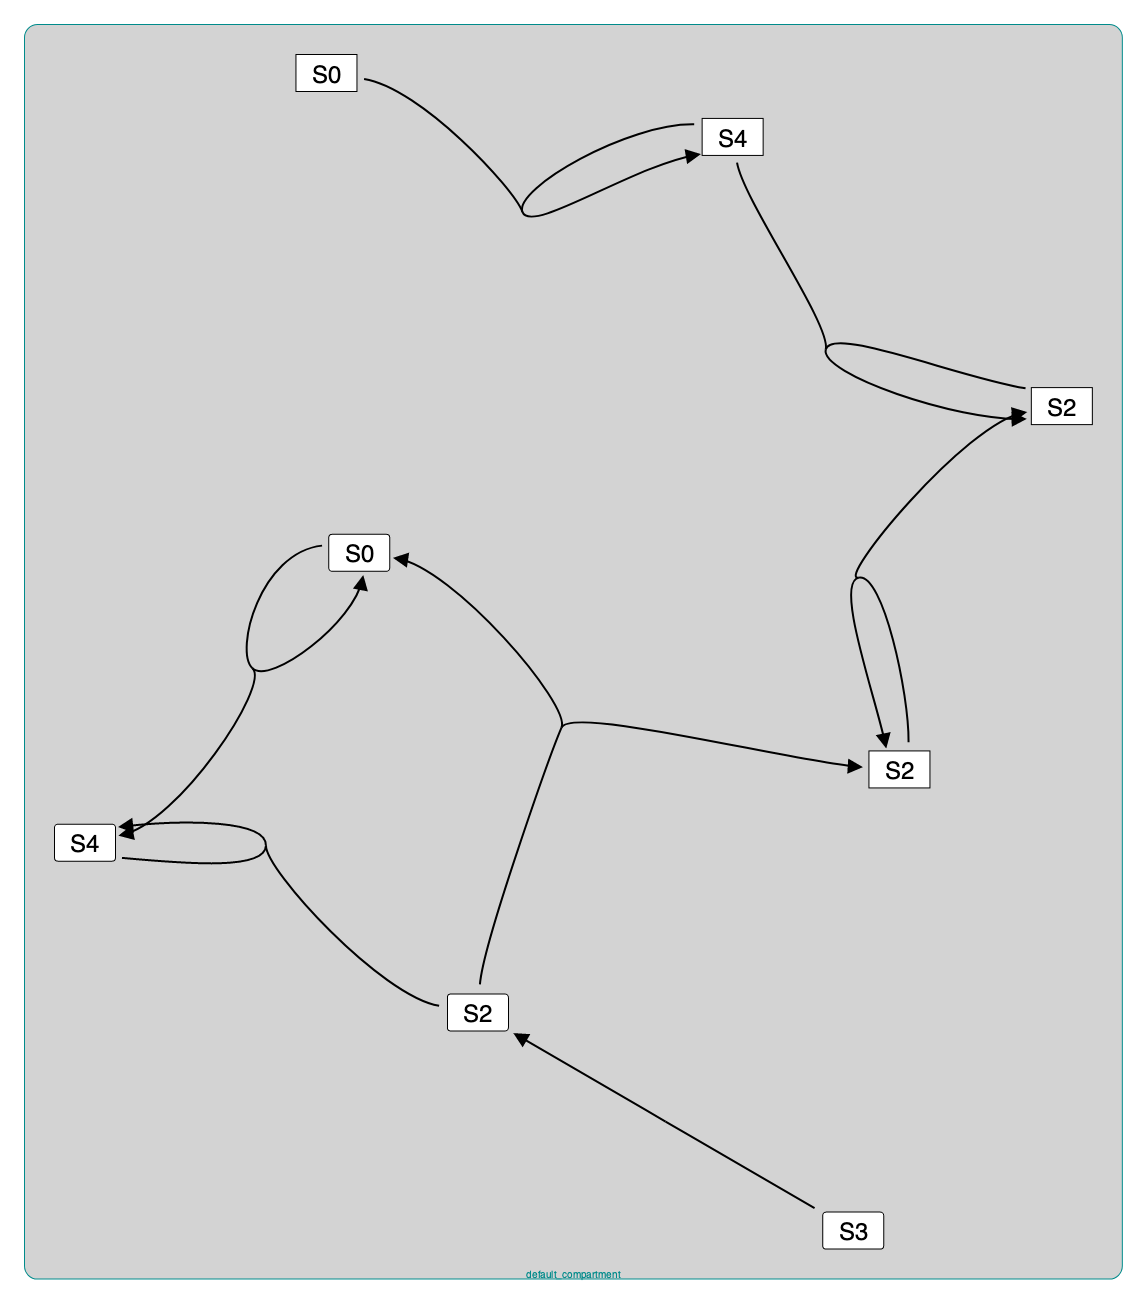

'BIOMD0000000480'

In [28]:

drawModel(matched_model)
target_network = BIOMODEL_NETWORKS[4]
target_network = BIOMODEL_NETWORKS[323]
target_network = BIOMODEL_NETWORKS[383]
target_network = BIOMODEL_NETWORKS[375] # BIOMD 375
reference_network = oscillator_collection.networks[165]
target_network.network_name

In [29]:
%%time
#model, model_prt = getBiomodel(608)
finder = SubnetFinder.makeFromCombinations( [reference_network], [target_network],
                 identity=cn.ID_WEAK)
df = finder.find(max_num_assignment=1e10)
#result = reference_network.isStructurallyIdentical( target_network, is_subset=True, identity=cn.ID_WEAK)
#result

Processing reference model: M9ODQLMW_XrH3X2B_4148_25


assignments: 100%|██████████| 269642210/269642210 [00:16<00:00, 16355583.98it/s]


Found matching model: M9ODQLMW_XrH3X2B_4148_25 and BIOMD0000000480
CPU times: user 8.21 s, sys: 2.41 s, total: 10.6 s
Wall time: 26.3 s


In [30]:
df

,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated
0,M9ODQLMW_XrH3X2B_4148_25,BIOMD0000000480,"M9ODQLMW_XrH3X2B_4148_25: 4 species, 7 reactio...",M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000480: 4 sp...,"{""species_names"": {""S2"": ""species_13"", ""S0"": ""...",150,False


In [31]:
target_network

BIOMD0000000480: 41 species, 88 reactions
  re2: s2 -> s3
  re3: s1 -> s6
  re4: s3 -> species_5
  re6: s6 + species_1 -> s9
  re11: s17 -> s15
  re13: s1 + s4 -> s9
  re15: s2 -> species_5
  re16: s22 -> s19
  re17: s22 -> s21
  re18: s21 -> s19
  re20: s6 + species_1 -> s25
  re21: s9 -> s26
  re22: s25 -> s27
  re23: s28 -> s30
  re24: s28 -> s31
  re27: s28 -> s33
  re28: s29 -> s30
  re29: s29 -> s31
  re31: s29 -> s33
  re32: s30 -> s16
  re33: s31 -> s13
  re35: s33 -> s15
  re41: s33 -> s30
  re42: s15 -> s16
  re43: s16 -> s17
  re44: s13 -> s17
  re45: s15 -> s17
  re46: s16 -> s29
  re47: s13 -> s29
  re49: s15 -> s29
  reaction_1: s3 -> s2
  reaction_2: species_5 -> s2
  reaction_3: s6 -> 2.0 s6
  reaction_4: s6 -> 
  reaction_5: s1 -> 2.0 s1
  reaction_6: s1 -> 
  reaction_10: s17 -> s13
  reaction_11: s17 -> s16
  reaction_12: s16 -> 
  reaction_13:  -> s28
  reaction_14: s28 -> 
  reaction_16: s1 -> s6
  reaction_17: s1 + s4 -> s25
  reaction_19: s6 -> 
  reaction_20: s1

In [32]:
print(df.loc[0, 'induced_network'])

M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000480: 4 species, 7 reactions
  reaction_46: species_12 -> species_13
  reaction_33:  -> s16
  reaction_47: species_13 -> 
  reaction_30:  -> s13
  reaction_39: s13 -> 
  reaction_48: species_13 -> 2.0 species_13
  reaction_12: s16 -> 


In [33]:
URL_480 = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1307130000/3/BIOMD0000000480_url.xml"
rr = te.loadSBMLModel(URL_480)
print(rr.getAntimony())

// Created by libAntimony v2.15.0
model *MODEL1307130000()

  // Compartments and Species:
  compartment c1, c2, c4, c3;
  species s1 in c1, $species_7 in c1, species_10 in c1, species_11 in c1;
  species species_12 in c1, species_13 in c1, species_14 in c1, species_15 in c1;
  species species_16 in c1, species_17 in c1, s9 in c2, s13 in c2, s15 in c2;
  species s16 in c2, s19 in c2, s21 in c2, s22 in c2, s25 in c2, s17 in c2;
  species s6 in c2, species_1 in c2, $species_2 in c2, s4 in c4, $species_3 in c2;
  species $species_4 in c2, species_18 in c2, species_19 in c2, s2 in c4;
  species s3 in c4, species_5 in c4, s26 in c3, s27 in c3, s28 in c3, s29 in c3;
  species s30 in c3, s31 in c3, s33 in c3, $species_6 in c3, $species_8 in c3;
  species $species_9 in c3, species_20 in c3;

  // Assignment Rules:
  species_2 := s9 + species_1 + s25 + s4;
  species_3 := s22 + s19 + s21;
  species_4 := s13 + s16 + s15 + s17;
  species_6 := s26 + s27;
  species_8 := s31 + s30 + s33 + s29 + s28;


In [34]:
print(df['induced_network'].values[0]) # 26 assignment pairs, 17M assignments, 0.3 sec

M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000480: 4 species, 7 reactions
  reaction_46: species_12 -> species_13
  reaction_33:  -> s16
  reaction_47: species_13 -> 
  reaction_30:  -> s13
  reaction_39: s13 -> 
  reaction_48: species_13 -> 2.0 species_13
  reaction_12: s16 -> 


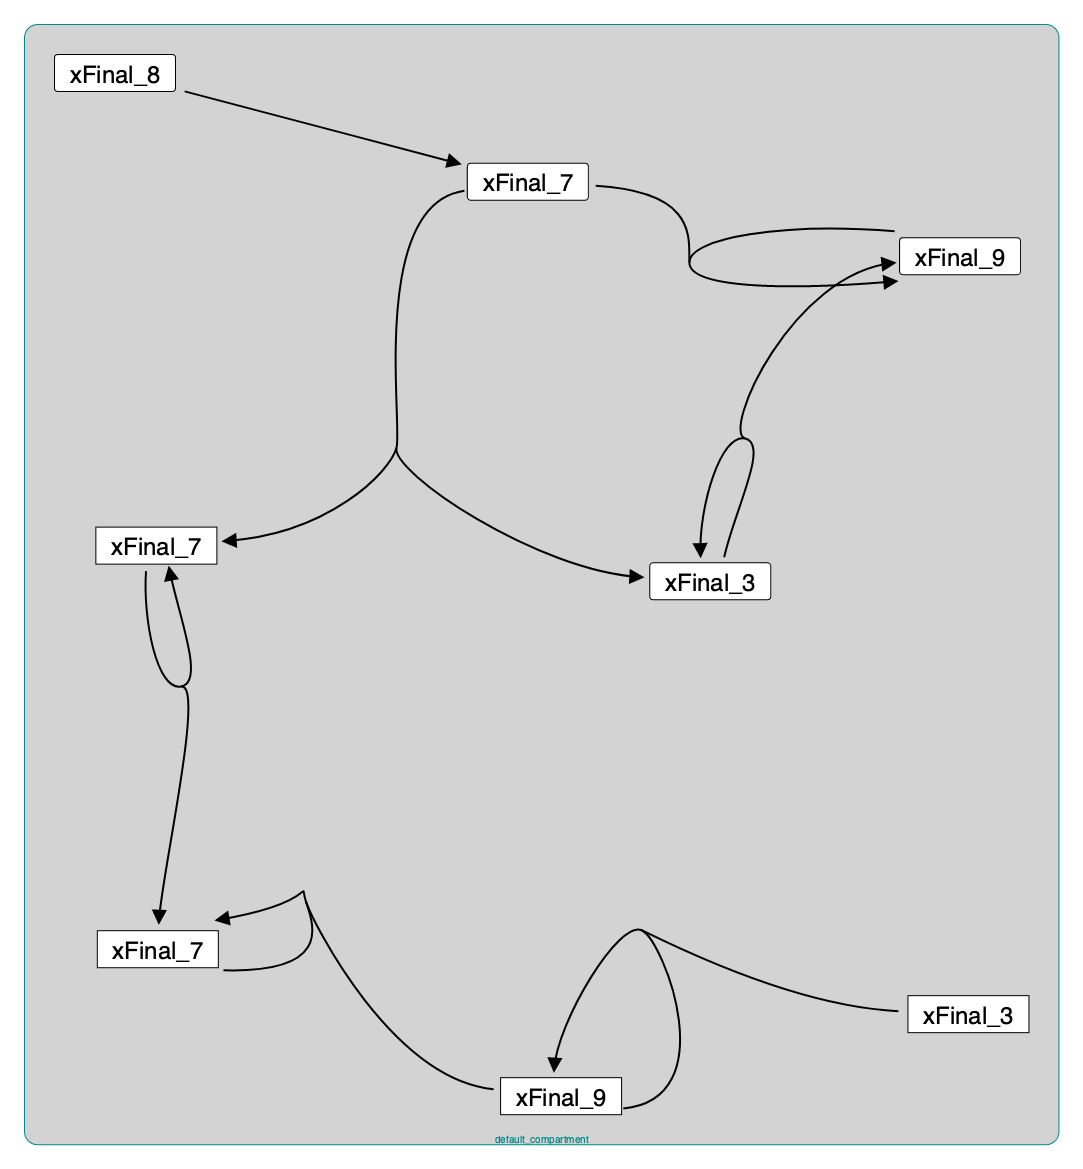

In [35]:
model = """
R_13: xFinal_8 -> xFinal_7; 1
  R_6: xFinal_3 -> xFinal_3 + xFinal_9; 1
  R_15: xFinal_7 + xFinal_9 -> xFinal_9; 1
  R_24: xFinal_7 -> xFinal_7 + xFinal_3; 1
  R_25: xFinal_3 + xFinal_9 -> xFinal_9; 1
  R_14: xFinal_7 -> 2.0 xFinal_7; 1
  R_7: xFinal_7 + xFinal_9 -> xFinal_7; 1
"""
drawModel(model)

In [36]:
print(df['induced_network'].values[0]) # 150 assignment pairs, 270M assignments, 8.85 sec

M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000480: 4 species, 7 reactions
  reaction_46: species_12 -> species_13
  reaction_33:  -> s16
  reaction_47: species_13 -> 
  reaction_30:  -> s13
  reaction_39: s13 -> 
  reaction_48: species_13 -> 2.0 species_13
  reaction_12: s16 -> 


In [37]:
print(df['induced_network'].values[0]) # 20 assignment pairs, 1.8M assignments, 0.065 sec

M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000480: 4 species, 7 reactions
  reaction_46: species_12 -> species_13
  reaction_33:  -> s16
  reaction_47: species_13 -> 
  reaction_30:  -> s13
  reaction_39: s13 -> 
  reaction_48: species_13 -> 2.0 species_13
  reaction_12: s16 -> 


In [38]:
[(i, n.network_name) for i, n in enumerate(BIOMODEL_NETWORKS) if "872" in n.network_name]

[(383, 'BIOMD0000000872')]

Biomodels containing this oscillator:
* 608: Palsson2013 - Fully-integrated immune response model (FIRM). Combines many immune response models. 140 reactions. (4)
* 695: 323 FelixGarza2017, Blue light treatment of psoriasis (35 reactions)
* 480: 375 Carbo2013 - Muscosal immune response during H.pylori infection (56 reactions)
*  reaction_16: s1 -> s6
  reaction_30: s16 -> s16 + s13
  reaction_19: s6 + s13 -> s13
  reaction_33: s6 -> s6 + s16
  reaction_12: s16 + s13 -> s13
  reaction_3: s6 -> 2.0 s6
  reaction_39: s6 + s13 -> s6
* 872: 383 Arnold2011_Farquhar1980RuBisCO-CalvinCycle (17 reactions)

# Bugs

Search failed

In [39]:
bug_network = """
//MxEPgDl6_VNGt1Ea_4270_5

S0 + S4 -> S4 + S4; S0*S4*0.366761065227911;
S0 + $S2 -> S0 + S0; S0*S2*0.979033777397126;
S4 -> $S1;  S4*0.517079830076545;
S4 -> $S1 + $S3;  S4*1.0408536597155;

S0 = 2; S1 = 5; S2 = 7; S3 = 10; S4 = 1;  
"""

# Hash Group Analysis

In [40]:
network_path = "/Users/jlheller/home/Technical/repos/pySubnetSB/data/Oscillators_DOE_JUNE_10_17565_serializers.txt"
network_path = "/Users/jlheller/home/Technical/repos/pySubnetSB/data/Oscillators_DOE_JUNE_12_B_41373_serializers.txt"

In [41]:
serializer = ModelSerializer(None, network_path)
collection = serializer.deserialize()
networks = collection.networks

In [42]:
hashes = [n.network_hash for n in networks]
len(hashes), len(np.unique(hashes))

(41373, 34075)

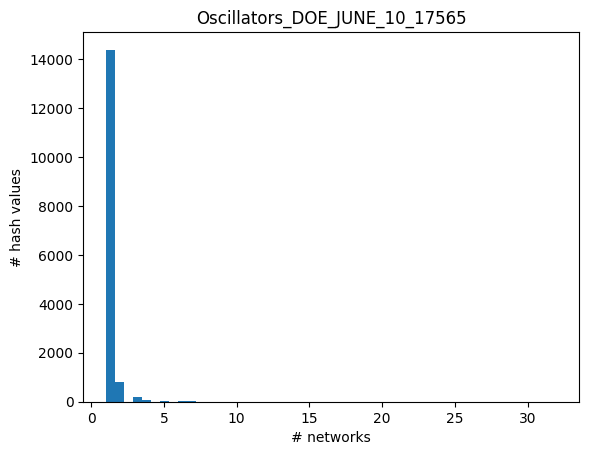

In [43]:
def plotHashInfo(oscillator_dir:str, is_plot=True):
    # Deserialize the network
    network_path = "/Users/jlheller/home/Technical/repos/pySubnetSB/data/" + oscillator_dir + "_serializers.txt"
    serializer = ModelSerializer(None, network_path)
    collection = serializer.deserialize()
    networks = collection.networks
    # Extract the size of each hash bin
    hashes = [n.network_hash for n in networks]
    df = pd.DataFrame({'value': hashes})
    dfg = df.groupby('value')
    groups = dfg.groups
    sizes = [len(v) for v in groups.values()]
    # Plot the bin sizes
    _ = plt.hist(sizes, bins=50)
    plt.xlabel("# networks")
    plt.ylabel("# hash values")
    plt.title(oscillator_dir)

# Test
plotHashInfo("Oscillators_DOE_JUNE_10_17565")

In [44]:
_ = plt.hist(sizes, bins=50)
plt.xlabel("# networks")
plt.ylabel("# hash values")

NameError: name 'sizes' is not defined

In [ ]:
plt.hist(hashes)